# RF-DETR Object Detection Project
# _Bungcaras-Nabablit_

In [1]:
# Install all required dependencies
!pip install -q roboflow \
                torch \
                torchvision \
                opencv-python \
                matplotlib \
                scipy \
                pillow \
                pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [2]:
# Import Packages

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet50
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from typing import Dict, List, Tuple
from scipy.optimize import linear_sum_assignment
import math
from collections import defaultdict

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="mi1FoW4XzP4sTfq1g4oi")
project = rf.workspace("data-sci-dinee").project("fall-detection-ca3o8-08ofs")
version = project.version(1)
dataset = version.download("coco")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fall-Detection-1 in coco:: 100%|██████████| 7652/7652 [00:02<00:00, 3750.21it/s]


In [4]:

class HardHatDataset(Dataset):
    """Custom dataset class for hard hat detection"""

    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        # Load COCO annotations
        with open(annotation_file, "r") as f:
            self.coco_data = json.load(f)

        # Create mappings
        self.images = {img["id"]: img for img in self.coco_data["images"]}
        # Correctly map category IDs to names, handling potential non-sequential IDs
        self.categories = {
            cat["id"]: cat["name"] for cat in self.coco_data["categories"]
        }
        self.cat_ids = sorted(self.categories.keys())
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.label2cat = {i: cat_id for i, cat_id in enumerate(self.cat_ids)}
        self.num_classes = len(self.categories)

        # Group annotations by image
        self.image_annotations = defaultdict(list)
        for ann in self.coco_data["annotations"]:
            self.image_annotations[ann["image_id"]].append(ann)

        self.image_ids = list(self.images.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]

        # Load image
        image_path = os.path.join(self.root_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")

        original_w, original_h = image.size

        # Get annotations for this image
        annotations = self.image_annotations[image_id]

        # Extract bounding boxes and labels
        boxes = []
        labels = []

        for ann in annotations:
            # COCO format: [x, y, width, height]
            x, y, w, h = ann["bbox"]
            # Convert to [x1, y1, x2, y2]
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat2label[ann["category_id"]])

        # Convert to tensors
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor(image_id),
            "orig_size": torch.as_tensor([int(original_h), int(original_w)]),
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


# Data preprocessing and augmentation
class CustomTransforms:
    def __init__(self, train=True):
        self.train = train
        self.resize = T.Resize((640, 640))
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        if self.train:
            self.random_flip = T.RandomHorizontalFlip(0.5)
            self.color_jitter = T.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2
            )

    def __call__(self, image, target):
        w, h = image.size

        # Apply augmentation if in training mode
        if self.train:
            if np.random.rand() < 0.5:
                image = self.random_flip(image)
                boxes = target["boxes"]
                boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
                target["boxes"] = boxes
            image = self.color_jitter(image)

        image = self.resize(image)
        image = self.to_tensor(image)
        image = self.normalize(image)

        # Scale bounding boxes
        boxes = target["boxes"]
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * (640 / w)
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * (640 / h)
        target["boxes"] = boxes

        return image, target


def get_transforms(train=True):
    return CustomTransforms(train)

In [5]:
# RF-DETR MODEL IMPLEMENTATION
class PositionalEncoding(nn.Module):
    """Positional encoding for transformer"""

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[: x.size(0), :]


class ReceptiveFieldEnhancement(nn.Module):
    """RF Enhancement module - key innovation of RF-DETR"""

    def __init__(self, d_model, num_heads=8):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # Multi-scale feature extraction
        self.conv1x1 = nn.Conv2d(d_model, d_model, 1)
        self.conv3x3 = nn.Conv2d(d_model, d_model, 3, padding=1)
        self.conv5x5 = nn.Conv2d(d_model, d_model, 5, padding=2)

        # Attention mechanism for RF enhancement
        self.rf_attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True)

        # Feature fusion
        self.fusion = nn.Conv2d(d_model * 3, d_model, 1)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x shape: [B, C, H, W]
        B, C, H, W = x.shape

        # Multi-scale feature extraction
        feat1 = self.conv1x1(x)
        feat3 = self.conv3x3(x)
        feat5 = self.conv5x5(x)

        # Concatenate multi-scale features
        multi_scale = torch.cat([feat1, feat3, feat5], dim=1)
        enhanced = self.fusion(multi_scale)

        # Apply attention for RF enhancement
        # Reshape for attention: [B, H*W, C]
        enhanced_flat = enhanced.flatten(2).transpose(1, 2)
        attended, _ = self.rf_attention(enhanced_flat, enhanced_flat, enhanced_flat)

        # Reshape back and apply normalization
        attended = attended.transpose(1, 2).reshape(B, C, H, W)
        attended_norm_flat = self.norm(attended.flatten(2).transpose(1, 2))
        attended = attended_norm_flat.transpose(1, 2).reshape(B, C, H, W)

        # Residual connection
        return x + attended


class RF_DETR(nn.Module):
    """RF-DETR: Receptive Field Enhanced Detection Transformer"""

    def __init__(self, num_classes, num_queries=100, hidden_dim=256):
        super().__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        self.hidden_dim = hidden_dim

        # CNN Backbone (ResNet-50)
        backbone = resnet50(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        # Project backbone features to hidden dimension
        self.input_proj = nn.Conv2d(2048, hidden_dim, kernel_size=1)

        # RF Enhancement Module
        self.rf_enhancement = ReceptiveFieldEnhancement(hidden_dim)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(hidden_dim)

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=8,
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=8,
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=True,
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)

        # Object queries
        self.query_embed = nn.Embedding(num_queries, hidden_dim)

        # Prediction heads
        self.class_embed = nn.Linear(
            hidden_dim, num_classes + 1
        )  # +1 for no-object class
        self.bbox_embed = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4),
        )

    def forward(self, images):
        # Extract features using backbone
        features = self.backbone(images)  # [B, 2048, H, W]

        # Project to hidden dimension
        features = self.input_proj(features)  # [B, hidden_dim, H, W]

        # Apply RF Enhancement
        enhanced_features = self.rf_enhancement(features)  # [B, hidden_dim, H, W]

        # Flatten spatial dimensions for transformer
        B, C, H, W = enhanced_features.shape
        features_flat = enhanced_features.flatten(2).transpose(1, 2)  # [B, H*W, C]

        # Get the correct slice of positional encoding
        seq_len = features_flat.shape[1]
        # self.pos_encoding.pe shape: [max_len, 1, hidden_dim]
        pos_embed = self.pos_encoding.pe[:seq_len, :].permute(1, 0, 2) # Shape -> [1, seq_len, hidden_dim]

        # Add positional encoding (it will broadcast across the batch dimension)
        features_with_pos = features_flat + pos_embed

        # Pass through transformer encoder
        memory = self.transformer_encoder(features_with_pos)  # [B, H*W, C]

        # Object queries
        query_embed = self.query_embed.weight.unsqueeze(0).repeat(
            B, 1, 1
        )  # [B, num_queries, C]

        # Pass through transformer decoder
        hs = self.transformer_decoder(query_embed, memory)  # [B, num_queries, C]

        # Prediction heads
        outputs_class = self.class_embed(hs)  # [B, num_queries, num_classes+1]
        outputs_coord = self.bbox_embed(hs).sigmoid()  # [B, num_queries, 4]

        return {"pred_logits": outputs_class, "pred_boxes": outputs_coord}


In [6]:
# HUNGARIAN MATCHER AND LOSS FUNCTIONS (No changes needed, generic implementation)
class HungarianMatcher(nn.Module):
    """Hungarian matcher for bipartite matching between predictions and ground truth"""

    def __init__(self, cost_class=1, cost_bbox=1, cost_giou=1):
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou

    def forward(self, outputs, targets):
        with torch.no_grad():
            batch_size, num_queries = outputs["pred_logits"].shape[:2]

            # Flatten to compute the cost matrices in a batch
            out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)
            out_bbox = outputs["pred_boxes"].flatten(0, 1)

            # Concatenate all target labels and boxes
            tgt_ids = torch.cat([v["labels"] for v in targets])
            tgt_bbox = torch.cat([v["boxes"] for v in targets])

            # Handle empty targets
            if len(tgt_bbox) == 0:
                return [
                    (
                        torch.tensor([], dtype=torch.int64),
                        torch.tensor([], dtype=torch.int64),
                    )
                    for _ in range(batch_size)
                ]

            # Normalize target boxes to [0, 1] for cxcywh format
            tgt_bbox_normalized = self.box_xyxy_to_cxcywh(tgt_bbox)
            tgt_bbox_normalized = tgt_bbox_normalized / torch.tensor(
                [640, 640, 640, 640], device=tgt_bbox.device
            )

            # Classification cost
            cost_class = -out_prob[:, tgt_ids]

            # L1 cost between boxes
            cost_bbox = torch.cdist(out_bbox, tgt_bbox_normalized, p=1)

            # GIoU cost
            cost_giou = -self.generalized_box_iou(
                self.box_cxcywh_to_xyxy(out_bbox),
                self.box_cxcywh_to_xyxy(tgt_bbox_normalized),
            )

            # Final cost matrix
            C = (
                self.cost_bbox * cost_bbox
                + self.cost_class * cost_class
                + self.cost_giou * cost_giou
            )
            C = C.view(batch_size, num_queries, -1)

            # Convert to CPU and detach for scipy
            C = C.detach().cpu()

            sizes = [len(v["boxes"]) for v in targets]
            indices = []

            for i, c in enumerate(C.split(sizes, -1)):
                if sizes[i] > 0:
                    row_indices, col_indices = linear_sum_assignment(c[i])
                    indices.append(
                        (
                            torch.as_tensor(row_indices, dtype=torch.int64),
                            torch.as_tensor(col_indices, dtype=torch.int64),
                        )
                    )
                else:
                    indices.append(
                        (
                            torch.tensor([], dtype=torch.int64),
                            torch.tensor([], dtype=torch.int64),
                        )
                    )
            return indices

    def box_cxcywh_to_xyxy(self, x):
        x_c, y_c, w, h = x.unbind(-1)
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return torch.stack(b, dim=-1)

    def box_xyxy_to_cxcywh(self, x):
        x0, y0, x1, y1 = x.unbind(-1)
        b = [(x0 + x1) / 2, (y0 + y1) / 2, (x1 - x0), (y1 - y0)]
        return torch.stack(b, dim=-1)

    def generalized_box_iou(self, boxes1, boxes2):
        assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
        assert (boxes2[:, 2:] >= boxes2[:, :2]).all()

        iou, union = self.box_iou(boxes1, boxes2)

        lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
        rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

        wh = (rb - lt).clamp(min=0)
        area = wh[:, :, 0] * wh[:, :, 1]

        return iou - (area - union) / (area + 1e-6)

    def box_iou(self, boxes1, boxes2):
        area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
        area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

        lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
        rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

        wh = (rb - lt).clamp(min=0)
        inter = wh[:, :, 0] * wh[:, :, 1]

        union = area1[:, None] + area2 - inter
        iou = inter / (union + 1e-6)
        return iou, union


class SetCriterion(nn.Module):
    """Loss computation for RF-DETR"""

    def __init__(self, num_classes, matcher, weight_dict):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict

        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = 0.1  # Lower weight for no-object class
        self.register_buffer("empty_weight", empty_weight)

    def forward(self, outputs, targets):
        indices = self.matcher(outputs, targets)
        losses = {}
        losses.update(self.loss_labels(outputs, targets, indices))
        losses.update(self.loss_boxes(outputs, targets, indices))
        return losses

    def loss_labels(self, outputs, targets, indices):
        src_logits = outputs["pred_logits"]
        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat(
            [t["labels"][J] for t, (_, J) in zip(targets, indices)]
        )
        target_classes = torch.full(
            src_logits.shape[:2],
            self.num_classes,
            dtype=torch.int64,
            device=src_logits.device,
        )
        target_classes[idx] = target_classes_o
        loss_ce = F.cross_entropy(
            src_logits.transpose(1, 2), target_classes, self.empty_weight
        )
        return {"loss_ce": loss_ce}

    def loss_boxes(self, outputs, targets, indices):
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs["pred_boxes"][idx]
        target_boxes = torch.cat(
            [t["boxes"][i] for t, (_, i) in zip(targets, indices)], dim=0
        )

        if len(target_boxes) == 0:
            return {
                "loss_bbox": torch.tensor(0.0, device=outputs["pred_boxes"].device),
                "loss_giou": torch.tensor(0.0, device=outputs["pred_boxes"].device),
            }

        target_boxes_normalized = self.matcher.box_xyxy_to_cxcywh(
            target_boxes
        ) / torch.tensor([640, 640, 640, 640], device=target_boxes.device)
        loss_bbox = F.l1_loss(src_boxes, target_boxes_normalized, reduction="none")

        src_boxes_xyxy = self.matcher.box_cxcywh_to_xyxy(src_boxes)
        target_boxes_xyxy = self.matcher.box_cxcywh_to_xyxy(target_boxes_normalized)
        loss_giou = 1 - torch.diag(
            self.matcher.generalized_box_iou(src_boxes_xyxy, target_boxes_xyxy)
        )

        return {
            "loss_bbox": loss_bbox.sum() / len(target_boxes),
            "loss_giou": loss_giou.sum() / len(target_boxes),
        }

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat(
            [torch.full_like(src, i) for i, (src, _) in enumerate(indices)]
        )
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx



In [7]:
# TRAINING SETUP
def find_dataset_path():
    """Find the correct dataset path after download"""
    import glob

    # UPDATED to look for the user's specific folder name first
    possible_paths = ["Fall-Detection-1", "fall-detection-*", "*/train"]

    for pattern in possible_paths:
        matches = glob.glob(pattern)
        if matches:
            base_path = matches[0]
            if "train" in base_path:
                base_path = os.path.dirname(base_path)
            print(f"Found dataset folder at: {base_path}")
            return base_path

    raise FileNotFoundError(
        "Could not find dataset directory. Please check the download."
    )


def download_and_setup_dataset():
    """Download dataset and return paths"""
    print("Downloading Hard Hat dataset from Roboflow...")
    try:
        from roboflow import Roboflow

        # UPDATED project details

        rf = Roboflow(api_key="mi1FoW4XzP4sTfq1g4oi")
        project = rf.workspace("data-sci-dinee").project("fall-detection-ca3o8-08ofs")
        version = project.version(1)
        dataset = version.download("coco")

        print("Dataset downloaded successfully!")
        dataset_path = find_dataset_path()
        print(f"Dataset found at: {dataset_path}")
        return dataset_path
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Trying to find existing dataset...")
        return find_dataset_path()


def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    dataset_path = download_and_setup_dataset()
    train_ann_file = os.path.join(dataset_path, "train", "_annotations.coco.json")
    val_ann_file = os.path.join(dataset_path, "valid", "_annotations.coco.json")
    test_ann_file = os.path.join(dataset_path, "test", "_annotations.coco.json")

    train_dataset = HardHatDataset(
        root_dir=os.path.join(dataset_path, "train"),
        annotation_file=train_ann_file,
        transforms=get_transforms(train=True),
    )
    val_dataset = HardHatDataset(
        root_dir=os.path.join(dataset_path, "valid"),
        annotation_file=val_ann_file,
        transforms=get_transforms(train=False),
    )
    test_dataset = HardHatDataset(
        root_dir=os.path.join(dataset_path, "test"),
        annotation_file=test_ann_file,
        transforms=get_transforms(train=False),
    )

    print(
        f"Dataset loaded! Train: {len(train_dataset)}, Valid: {len(val_dataset)}, Test: {len(test_dataset)}"
    )
    print(f"Number of classes: {train_dataset.num_classes}")

    train_loader = DataLoader(
        train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2
    )
    test_loader = DataLoader(
        test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2
    )

    num_classes = train_dataset.num_classes
    model = RF_DETR(num_classes=num_classes).to(device)

    matcher = HungarianMatcher()
    weight_dict = {"loss_ce": 1, "loss_bbox": 5, "loss_giou": 2}
    criterion = SetCriterion(num_classes, matcher, weight_dict).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    num_epochs = 10  # Increased epochs for better training
    best_val_loss = float("inf")
    patience = 10
    patience_counter = 0
    train_losses, val_losses = [], []

    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for images, targets in train_loader:
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            outputs = model(images)
            loss_dict = criterion(outputs, targets)
            total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys())

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            optimizer.step()
            epoch_train_loss += total_loss.item()

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                outputs = model(images)
                loss_dict = criterion(outputs, targets)
                total_loss = sum(
                    loss_dict[k] * weight_dict[k] for k in loss_dict.keys()
                )
                epoch_val_loss += total_loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(
            f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
        )

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_rf_detr_model.pth")
            print(f"✓ New best model saved with val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
        scheduler.step()

    print("Training completed!")
    return model, train_losses, val_losses, test_loader, test_dataset


def collate_fn(batch):
    """Custom collate function for DataLoader"""
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets


In [8]:
# EVALUATION FUNCTIONS (No changes needed, generic implementation)
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = (
        max(box1[0], box2[0]),
        max(box1[1], box2[1]),
        min(box1[2], box2[2]),
        min(box1[3], box2[3]),
    )
    if x2 <= x1 or y2 <= y1:
        return 0.0
    intersection = (x2 - x1) * (y2 - y1)
    area1, area2 = (
        (box1[2] - box1[0]) * (box1[3] - box1[1]),
        (box2[2] - box2[0]) * (box2[3] - box2[1]),
    )
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0.0


# ... [The rest of the evaluation and visualization functions from the original script]
# ... [No changes are needed for evaluate_model, calculate_metrics, calculate_map, visualize_predictions, etc.]
# ... [They are generic and will adapt to the new dataset]


def evaluate_model(model, test_loader, device, iou_threshold=0.5):
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            outputs = model(images)
            for i in range(len(images)):
                logits, boxes = outputs["pred_logits"][i], outputs["pred_boxes"][i]
                scores = F.softmax(logits, dim=-1)
                max_scores, pred_classes = scores.max(dim=-1)
                keep = (pred_classes < model.num_classes) & (max_scores > 0.5)

                final_boxes = boxes[keep].detach().cpu().numpy()
                final_boxes = final_boxes * np.array([640, 640, 640, 640])
                # Convert cxcywh to xyxy
                final_boxes[:, 0] = final_boxes[:, 0] - final_boxes[:, 2] / 2
                final_boxes[:, 1] = final_boxes[:, 1] - final_boxes[:, 3] / 2
                final_boxes[:, 2] = final_boxes[:, 0] + final_boxes[:, 2]
                final_boxes[:, 3] = final_boxes[:, 1] + final_boxes[:, 3]

                predictions = {
                    "scores": max_scores[keep].detach().cpu().numpy(),
                    "labels": pred_classes[keep].detach().cpu().numpy(),
                    "boxes": final_boxes,
                }
                all_predictions.append(predictions)
                all_targets.append(
                    {
                        k: v.cpu().numpy()
                        for k, v in targets[i].items()
                        if isinstance(v, torch.Tensor)
                    }
                )
    return (
        calculate_map(all_predictions, all_targets, iou_threshold),
        all_predictions,
        all_targets,
    )


def calculate_ap(rec, prec):
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def calculate_map(predictions, targets, iou_threshold=0.5):
    aps = []
    all_classes = set()
    for t in targets:
        all_classes.update(t["labels"])

    for c in all_classes:
        # Get all predictions and ground truths for this class
        class_preds = []
        n_gt = 0
        for i in range(len(predictions)):
            gt_labels = targets[i]["labels"]
            if c in gt_labels:
                n_gt += sum(gt_labels == c)

            pred_labels = predictions[i]["labels"]
            if c in pred_labels:
                mask = pred_labels == c
                for score, box in zip(
                    predictions[i]["scores"][mask], predictions[i]["boxes"][mask]
                ):
                    class_preds.append({"score": score, "box": box, "img_idx": i})

        if n_gt == 0:
            continue

        class_preds.sort(key=lambda x: x["score"], reverse=True)

        tp = np.zeros(len(class_preds))
        fp = np.zeros(len(class_preds))

        # Keep track of matched ground truth boxes for each image
        matched_gt = defaultdict(list)

        for i, pred in enumerate(class_preds):
            img_idx = pred["img_idx"]
            gt_boxes = targets[img_idx]["boxes"][targets[img_idx]["labels"] == c]

            best_iou = 0
            best_gt_idx = -1
            for j, gt_box in enumerate(gt_boxes):
                iou = calculate_iou(pred["box"], gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j

            if best_iou >= iou_threshold and best_gt_idx not in matched_gt[img_idx]:
                tp[i] = 1
                matched_gt[img_idx].append(best_gt_idx)
            else:
                fp[i] = 1

        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp / (n_gt + 1e-6)
        prec = tp / (tp + fp + 1e-6)

        ap = calculate_ap(rec, prec)
        aps.append(ap)

    return np.mean(aps) if aps else 0.0


def visualize_predictions(model, test_dataset, device, num_images=5):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(25, 5))
    if num_images == 1:
        axes = [axes]

    class_names = [
        test_dataset.categories[test_dataset.label2cat[i]]
        for i in range(test_dataset.num_classes)
    ]
    colors = plt.cm.get_cmap("tab10", test_dataset.num_classes)

    with torch.no_grad():
        for i in range(num_images):
            image, target = test_dataset[i]
            image_tensor = image.unsqueeze(0).to(device)
            outputs = model(image_tensor)

            # Un-normalize image for display
            img_display = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)

            ax = axes[i]
            ax.imshow(img_display)
            ax.set_title(f"Image {i + 1}")
            ax.axis("off")

            # Process and draw predictions
            logits, boxes = outputs["pred_logits"][0], outputs["pred_boxes"][0]
            scores = F.softmax(logits, dim=-1)
            max_scores, pred_classes = scores.max(dim=-1)
            keep = (pred_classes < model.num_classes) & (
                max_scores > 0.7
            )  # Higher confidence for viz

            final_boxes = boxes[keep].detach().cpu().numpy() * 640
            final_scores = max_scores[keep].detach().cpu().numpy()
            final_classes = pred_classes[keep].detach().cpu().numpy()

            for box, score, cls_id in zip(final_boxes, final_scores, final_classes):
                x_c, y_c, w, h = box
                x1, y1 = x_c - w / 2, y_c - h / 2
                rect = plt.Rectangle(
                    (x1, y1), w, h, fill=False, color=colors(cls_id), linewidth=2
                )
                ax.add_patch(rect)
                ax.text(
                    x1,
                    y1 - 5,
                    f"{class_names[cls_id]}: {score:.2f}",
                    color="white",
                    bbox=dict(facecolor=colors(cls_id), alpha=0.8),
                )

    plt.tight_layout()
    plt.show()

=== STEP 5: MAIN EXECUTION ===
Starting RF-DETR Hard Hat Detection Project
Using device: cuda
loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded successfully!
Found dataset folder at: Fall-Detection-1
Dataset found at: Fall-Detection-1
Dataset loaded! Train: 6296, Valid: 899, Test: 450
Number of classes: 2


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


Starting training for 10 epochs...
Epoch 0: Train Loss: 3.5497, Val Loss: 5.6547
✓ New best model saved with val loss: 5.6547
Epoch 1: Train Loss: 3.1628, Val Loss: 6.1869
Epoch 2: Train Loss: 3.0055, Val Loss: 4.8459
✓ New best model saved with val loss: 4.8459
Epoch 3: Train Loss: 2.8713, Val Loss: 5.3123
Epoch 4: Train Loss: 2.8243, Val Loss: 5.6984
Epoch 5: Train Loss: 2.8655, Val Loss: 5.7581
Epoch 6: Train Loss: 2.8566, Val Loss: 6.4572
Epoch 7: Train Loss: 2.8680, Val Loss: 7.6620
Epoch 8: Train Loss: 2.8058, Val Loss: 6.5631
Epoch 9: Train Loss: 2.8035, Val Loss: 6.8955
Training completed!

2. Evaluating model...

3. Results:
mAP@0.5: 0.0000


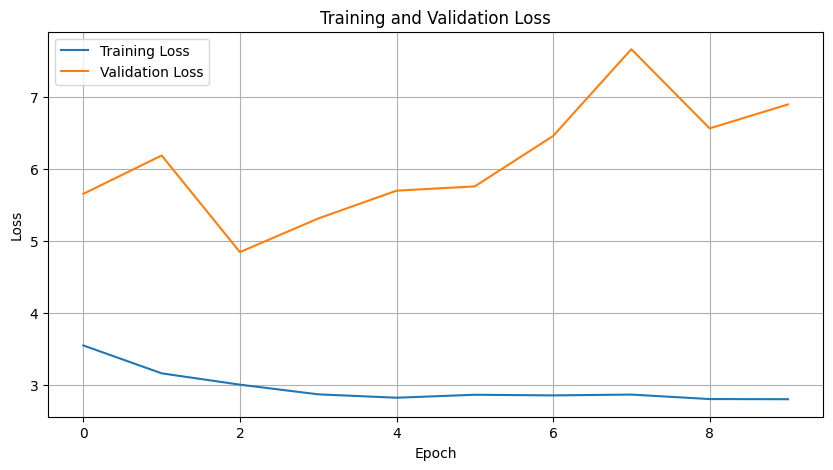


4. Visualizing predictions...


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


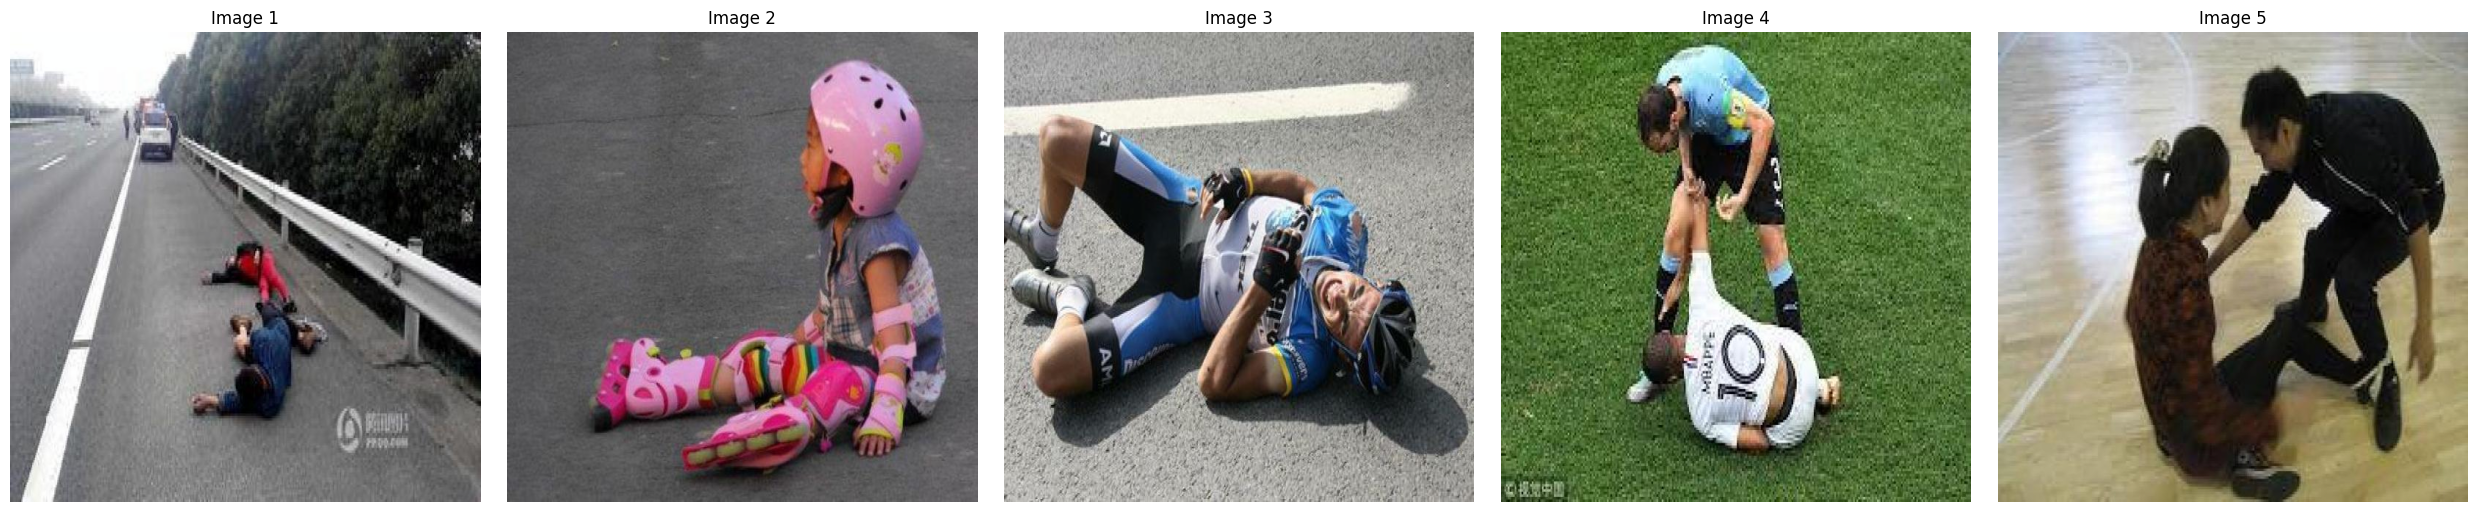

In [9]:
# 6. MAIN EXECUTION
print("=== STEP 5: MAIN EXECUTION ===")

if __name__ == "__main__":
    print("Starting RF-DETR Hard Hat Detection Project")
    print("=" * 50)

    try:
        model, train_losses, val_losses, test_loader, test_dataset = train_model()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.load_state_dict(torch.load("best_rf_detr_model.pth", map_location=device))

        print("\n2. Evaluating model...")
        mAP, predictions, targets = evaluate_model(model, test_loader, device)

        print("\n3. Results:")
        print(f"mAP@0.5: {mAP:.4f}")

        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        print("\n4. Visualizing predictions...")
        visualize_predictions(model, test_dataset, device, num_images=5)

    except Exception as e:
        print(f"\n✗ Project failed with error: {e}")
        import traceback

        traceback.print_exc()
